In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install SimpSOM
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

## Aux functions

In [2]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Dataset Energy Appliances

In [4]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [5]:
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

### Dataset Energy Appliances: columns

In [6]:
cols = data.columns
list_cols = list(cols)
list_cols.append('Appliances_t+1')
print(list_cols)

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Appliances_t+1']


### Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [7]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


In [8]:
data = pd.DataFrame(reframed.values,columns=list_cols)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances_t+1
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


### Model: AutoencoderWeightedMVFTS - AE-MVFTS

In [16]:
# No treinamento eu recebo os dados de treino completo, a variável alvo e a epocas
# Faço o treinamento do AE e a redução dos dados de treino.
# Crio o modelo WMVFTS e treino ele com os dados "encodificados (com dimensão reduzida)" 
def train_reducted(train, Y, input_layers, output_layers, epochs):
    
    input_layer = Input(shape=(input_layers, ))
    encoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder_layer_2 = Dense(4, activation="tanh")(encoder_layer_1)

    decoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(encoder_layer_2)
    decoder_layer_2 = Dense(input_layers, activation="tanh")(decoder_layer_1)

    autoencoder = Model(input_layer, decoder_layer_2)
    autoencoder.compile(optimizer = 'adam', loss='mse')
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train)
    autoencoder.fit(x=X_train, y=X_train, epochs=epochs)

    encoder_model = Model(inputs=input_layer, outputs=encoder_layer_2)

    encoded_train = pd.DataFrame(encoder_model.predict(X_train))
    encoded_train.columns = ['factor_1', 'factor_2','factor_3','factor_4']
    encoded_train = encoded_train.join(Y)
    
    VX1= variable.Variable("factor_1", data_label="factor_1", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX2= variable.Variable("factor_2", data_label="factor_2", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX3= variable.Variable("factor_3", data_label="factor_3", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX4= variable.Variable("factor_4", data_label="factor_4", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VY = variable.Variable("Appliances", data_label="Appliances_t+1", partitioner   = Grid.GridPartitioner, npart=50,   data=encoded_train ) 

    fts_model = pyFTS.models.multivariate.wmvfts.WeightedMVFTS(explanatory_variables=[VX1, VX2, VX3, VX4, VY], target_variable=VY)
    fts_model.fit(encoded_train)

    return fts_model, encoder_model, encoded_train


In [17]:
# No treino eu recebo o modelo WMVFTS treinado, o AE treinado, os dados te teste e a variável alvo
# Eu uso o AE treinado para reduzir a dimensão dos dados do treino
# Eu uso o WMVFTS treinado para fazer a previsão passando os dados de teste reduzidos
def forecast_reducted(fts_model, encoder_model,test, Y):
        
    scaler = MinMaxScaler()
    X_test = scaler.fit_transform(test)
    
    encoded_test = pd.DataFrame(encoder_model.predict(X_test))
    encoded_test.columns = ['factor_1', 'factor_2','factor_3','factor_4']
    encoded_test = encoded_test.join(Y)
    
    forecasts = fts_model.predict(encoded_test)

    return forecasts, encoded_test

## Sliding Window PyFTS: AE-WMVFTS

--------------------
training window 0
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2998
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1934
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1452
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1115
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0691
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0567
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0476
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0439
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0425
Epoch 13/5

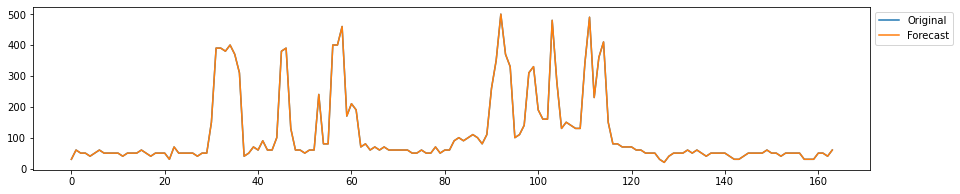

--------------------
training window 657
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2502
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1812
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1256
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0892
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0660
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0564
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0505
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0458
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0442
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0424
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 13

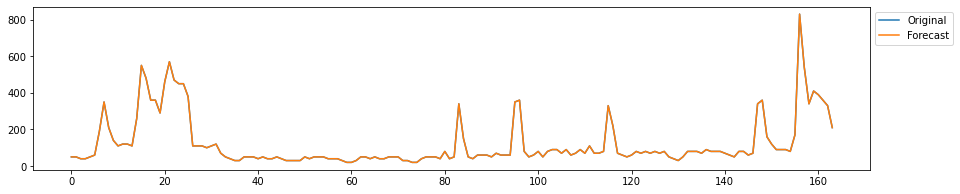

--------------------
training window 1314
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.3078
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2391
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1938
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1558
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1152
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0875
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0699
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0621
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0538
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 1

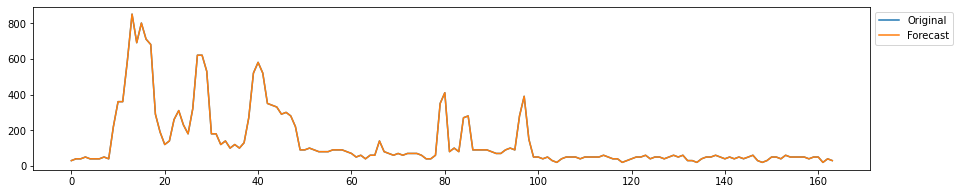

--------------------
training window 1971
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2334
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1787
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1315
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0757
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0518
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0464
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0445
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0389
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 1

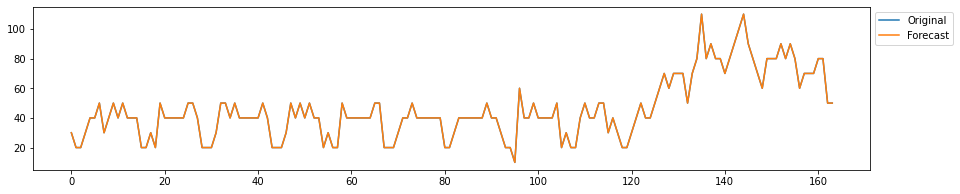

--------------------
training window 2628
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2613
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1926
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1414
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1067
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0865
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0708
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0643
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0604
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0583
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0537
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0517
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0501
Epoch 1

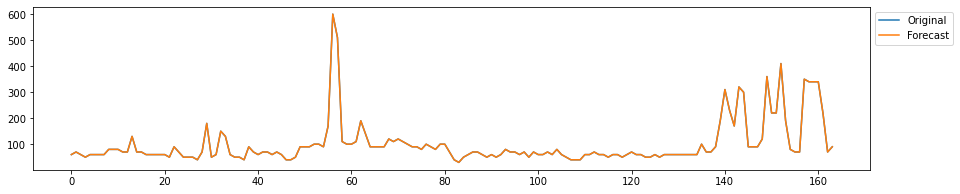

--------------------
training window 3285
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2884
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2188
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1602
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1173
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0864
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0681
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0467
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0445
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 1

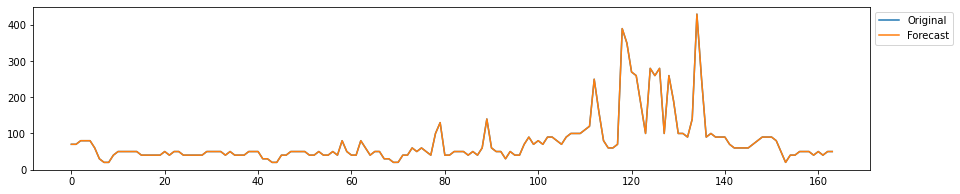

--------------------
training window 3942
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2962
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2303
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1947
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1585
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1284
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1006
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0784
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0653
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0586
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0532
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 1

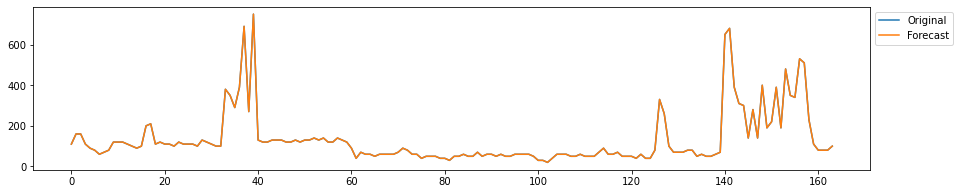

--------------------
training window 4599
Epoch 1/50
16/16 [==============================] - 1s 946us/step - loss: 0.2674
Epoch 2/50
16/16 [==============================] - 0s 999us/step - loss: 0.2078
Epoch 3/50
16/16 [==============================] - 0s 963us/step - loss: 0.1633
Epoch 4/50
16/16 [==============================] - 0s 993us/step - loss: 0.1213
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0905
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0674
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0576
Epoch 8/50
16/16 [==============================] - 0s 998us/step - loss: 0.0514
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0457
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.04

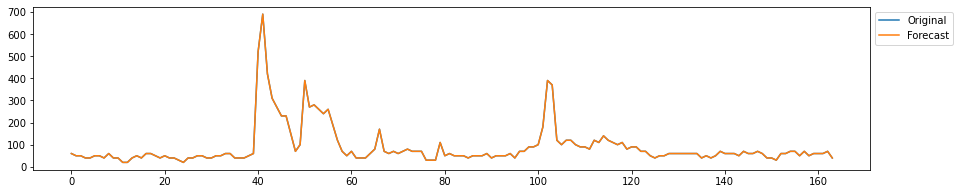

--------------------
training window 5256
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2268
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1630
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1283
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0981
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0744
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0588
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0488
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0444
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0429
Epoch 1

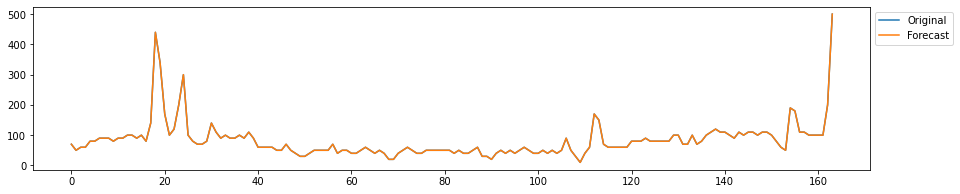

--------------------
training window 5913
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2964
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2521
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2019
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1545
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1135
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0811
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0589
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0540
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0486
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 1

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 22:35:48] getting statistics


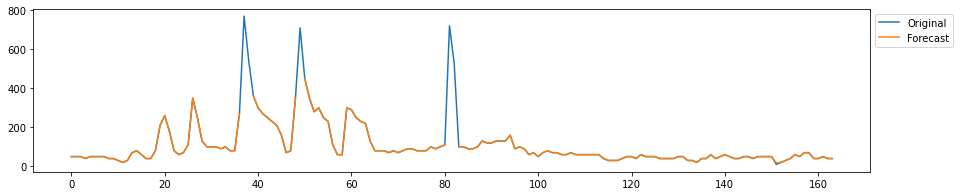

--------------------
training window 6570
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2696
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2019
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1622
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1162
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0813
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0626
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0451
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0421
Epoch 1

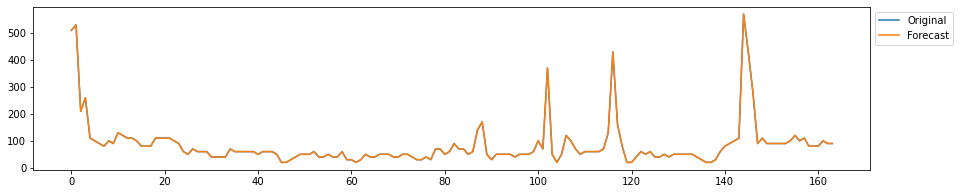

--------------------
training window 7227
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2132
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1632
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1203
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0904
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0679
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0579
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0520
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0496
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0496
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0483
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 1

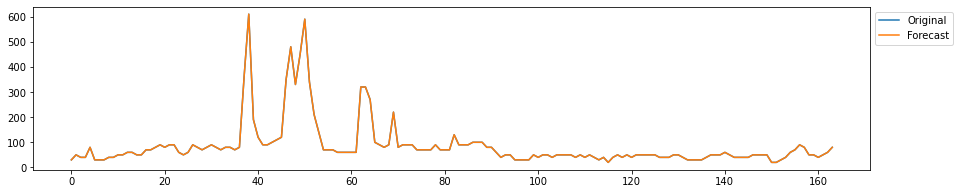

--------------------
training window 7884
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2427
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2065
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1686
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1298
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0983
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0663
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0574
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0492
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0479
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 1

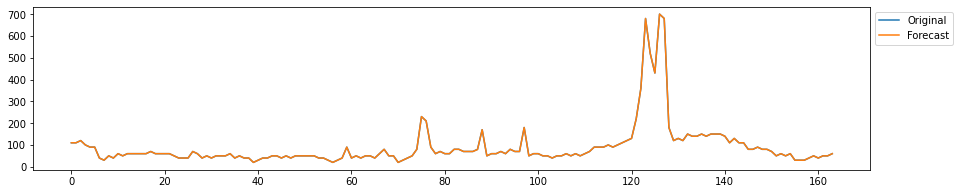

--------------------
training window 8541
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.3267
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2600
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2246
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1836
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1394
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0764
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0632
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0581
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0527
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 1

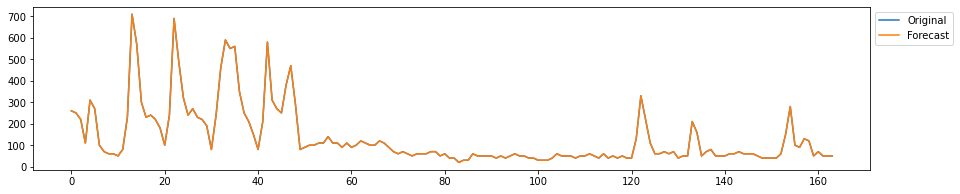

--------------------
training window 9198
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2652
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1998
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1585
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1150
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0871
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0722
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0666
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0632
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0625
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0613
Epoch 11/50
16/16 [==============================] - 0s 974us/step - loss: 0.0591
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch

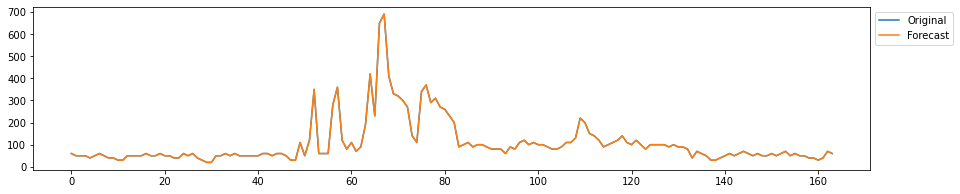

--------------------
training window 9855
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2433
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1954
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1446
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1122
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0721
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0560
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0515
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0485
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0448
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0428
Epoch 1

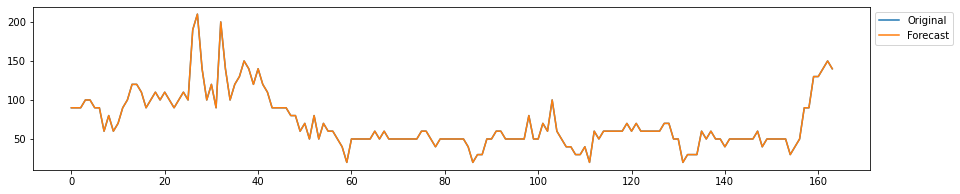

--------------------
training window 10512
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2604
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2079
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1614
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1220
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0935
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0631
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0549
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0468
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0442
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 

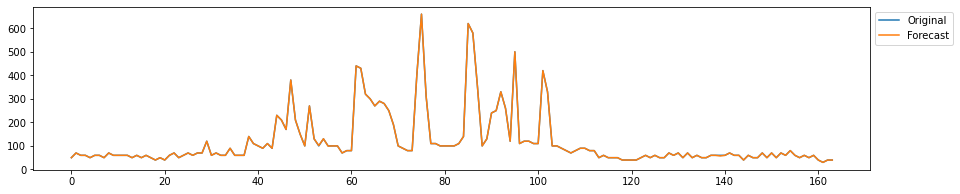

--------------------
training window 11169
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2810
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2141
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1674
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1282
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0973
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0758
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0637
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0549
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0497
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0477
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0454
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 

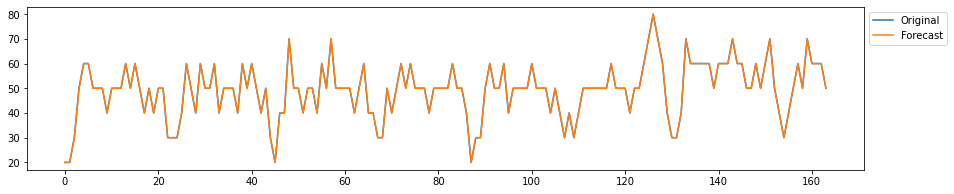

--------------------
training window 11826
Epoch 1/50
16/16 [==============================] - 1s 3ms/step - loss: 0.2323
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1599
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1172
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0888
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0586
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0529
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0516
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0515
Epoch 

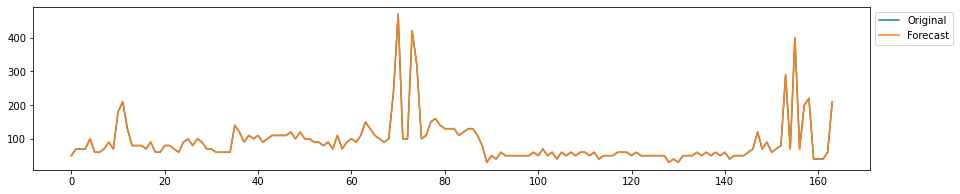

--------------------
training window 12483
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2485
Epoch 2/50
16/16 [==============================] - 0s 928us/step - loss: 0.1828
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1402
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1020
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0795
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0632
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0544
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0515
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0472
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0454
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0438
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0421
Epoc

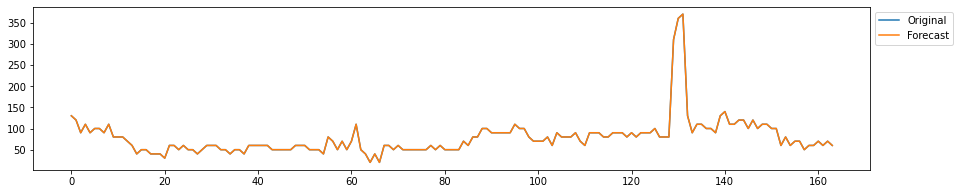

--------------------
training window 13140
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2988
Epoch 2/50
16/16 [==============================] - 0s 952us/step - loss: 0.2231
Epoch 3/50
16/16 [==============================] - 0s 955us/step - loss: 0.1838
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1500
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1231
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1039
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0878
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0637
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0578
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0528
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0514
Ep

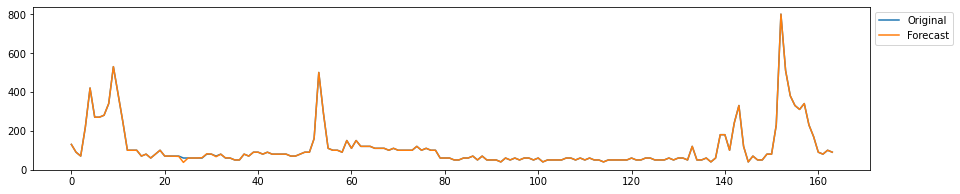

--------------------
training window 13797
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2345
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1867
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1511
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1134
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0889
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0739
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0623
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0569
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0530
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0511
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0465
Epoch 

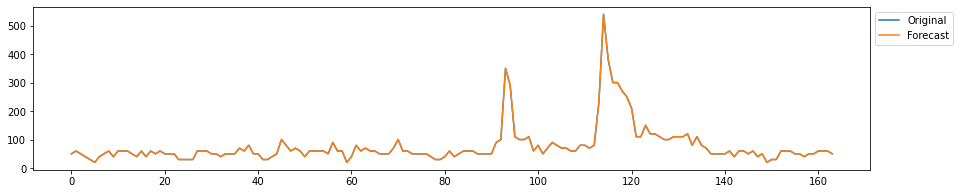

--------------------
training window 14454
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2945
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2118
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1599
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1207
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0961
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0741
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0575
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0542
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0502
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 

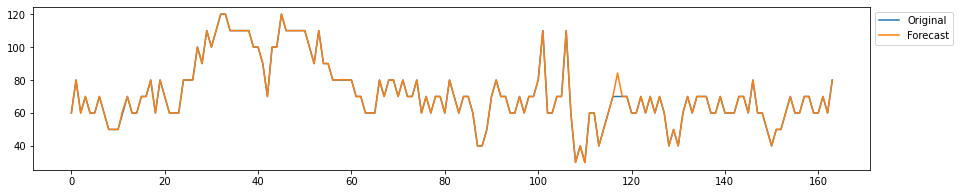

--------------------
training window 15111
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2747
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1740
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1198
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0842
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0653
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0560
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0496
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 22:37:14] getting statistics


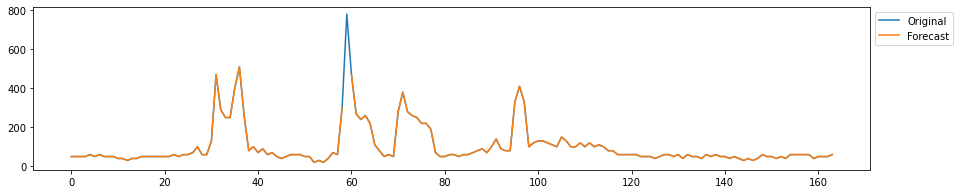

--------------------
training window 15768
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2866
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2169
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1757
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1443
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1132
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0885
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0730
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0663
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0608
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0575
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0555
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0554
Epoch 

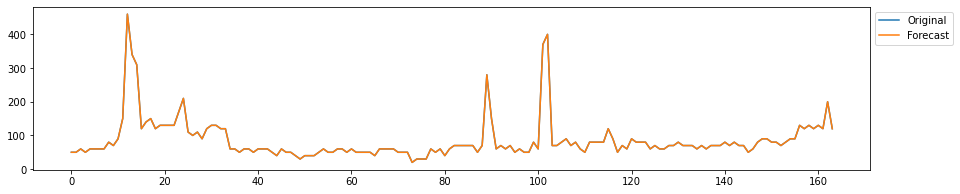

--------------------
training window 16425
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.3061
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2347
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1804
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1305
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0988
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0772
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0631
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0561
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0529
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0494
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0465
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 

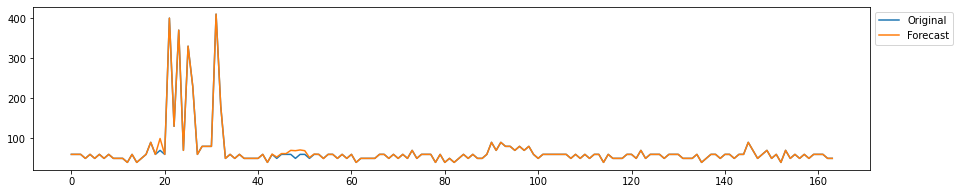

--------------------
training window 17082
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.3201
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2581
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2104
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1638
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1282
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0808
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0670
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0459
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0428
Epoch 

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 22:37:32] getting statistics


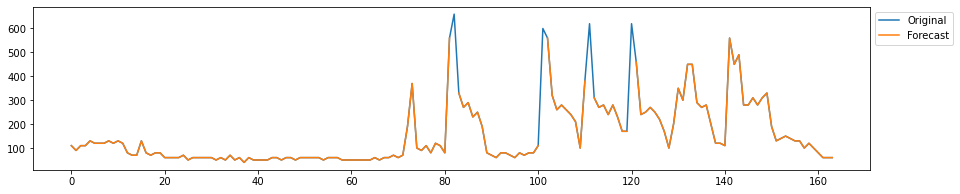

--------------------
training window 17739
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2584
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2096
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1577
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1166
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0934
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0734
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0645
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0599
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0556
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0544
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0528
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0522
Epoch 

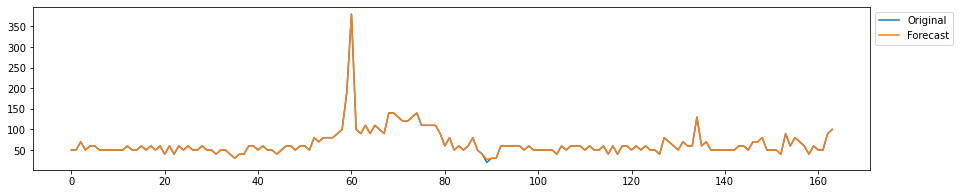

--------------------
training window 18396
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.3105
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2321
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1988
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1501
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1191
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0987
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0736
Epoch 9/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0667
Epoch 10/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 

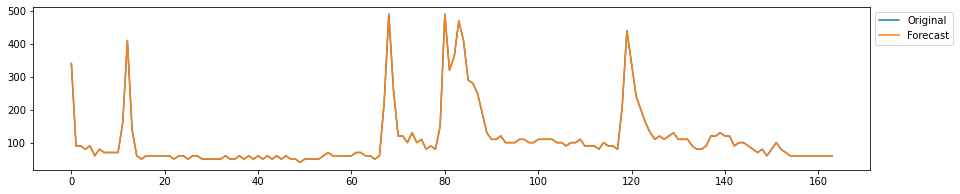

--------------------
training window 19053
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2725
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2254
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1691
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1281
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0976
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0828
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0605
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0496
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 

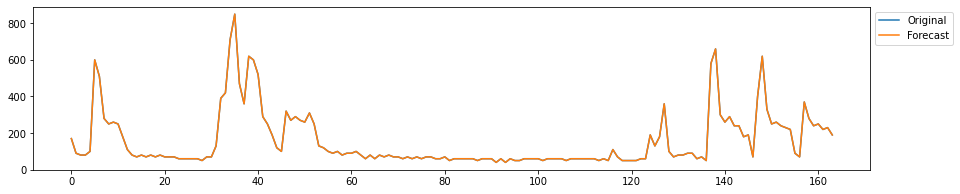

In [18]:
input_layers = 26
output_layers = 2 
epocs = 50

result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        appliance = ttest['Appliances_t+1'].reset_index()
        appliance_train = ttrain['Appliances_t+1'].reset_index()
        print('-' * 20)
        print(f'training window {(ct)}')
        # Faz o treinamento 
        fts_model, encoder_model, encoded_train = train_reducted(ttrain.loc[:,'Appliances':'Tdewpoint'], 
                                                                 appliance_train, input_layers,
                                                                 output_layers, epocs)
        # Faz o teste 
        forecast, encoded_test = forecast_reducted(fts_model, encoder_model,ttest.loc[:,'Appliances':'Tdewpoint'],
                                                   appliance)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        appliance.pop('index')
        rmse = Measures.rmse(encoded_test['Appliances_t+1'],forecast)
        mape = Measures.mape(encoded_test['Appliances_t+1'],forecast)
        smape = Measures.smape(encoded_test['Appliances_t+1'],forecast)
        
        #forecasts.append(forecast)
        #appliances.append(appliance)
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(encoded_test['Appliances_t+1'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()

measures = pd.DataFrame(result)



In [19]:
measures

,window,rmse,mape,smape
0,0,1.560474e-14,7.014500e-15,3.507250e-15
1,657,2.443032e-14,2.162389e-15,1.081194e-15
2,1314,8.451847e-02,1.649946e-02,8.139604e-03
3,1971,1.922024e-15,2.441998e-16,1.220999e-16
4,2628,2.935941e-15,3.129084e-16,1.564542e-16
5,3285,3.316911e-02,1.483489e-02,7.365074e-03
6,3942,1.200304e-14,2.390356e-15,1.195178e-15
7,4599,9.673977e-15,1.947994e-15,9.739971e-16
8,5256,8.613443e-15,4.192912e-15,2.096456e-15
9,5913,6.344433e-01,5.033019e-01,1.797731e-01


### Mean Statistics AE-WMVFTS

In [21]:
final_result = {
     "rmse": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics AE-WMVFTS (test): ")
final_measures_pca

Mean Statistics AE-WMVFTS (test): 


,rmse,mape,smape
0,0.26182,0.074356,0.033121


In [ ]:
#rmse	mape	smape ==> 3 components 
#1.4715	0.253807 0.110444

#rmse	mape	smape ==> 4 components
#0.26182	0.074356	0.033121